# Mean Shift Clustering

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [232]:
import numpy as np
import pandas as pd
from copy import copy

class mean_shift:
    
    def __init__(self, bandwidth=1, iters=10, threshold = .1):
        self._iters = iters
        self.bandwidth = bandwidth
        self.data_cols = None
        self.threshold = threshold
        
    def fit(self, X):
        X = self.pandas_to_numpy(X)
        if not self.data_cols:
            self.data_cols = X.shape[1]
        self.check_feature_shape(X)
        self._original_data = copy(X)
        
    def transform(self, X):
        X = self.pandas_to_numpy(X)
        if not self.data_cols:
            self.data_cols = X.shape[1]
        X = self.check_feature_shape(X)
        new_X = []
        for pt in X:
            movement = self.threshold+1
            it=0
            p = copy(pt)
            while it < self._iters and movement > self.threshold:
                shift = np.zeros(len(p))
                scale = 0.
                for orig_pt in self._original_data:
                    weight = self.rbf_kernel(p, orig_pt, sig=self.bandwidth)
                    shift += weight*orig_pt
                    scale += weight
                movement = p - shift/scale
                p = shift/scale
                movement = np.sqrt(np.sum(movement**2))
                it+=1
            new_X.append(p)
        return new_X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
        
    def check_feature_shape(self, x):
        """
        Helper function to make sure any new data conforms to the fit data shape
        ---
        In: numpy array, (unknown shape)
        Out: numpy array, shape: (rows, self.data_cols)"""
        return x.reshape(-1,self.data_cols)
        
    def rbf_kernel(self, x1, x2, sig=1.):
        """
        Returns the rbf affinity between two points (x1 and x2),
        for a given bandwidth (standard deviation).
        ---
        Inputs: 
            x1; point 1(array)
            x2; point 2(array)
            sig; standard deviation (float)
        """
        diff = np.sum((x1-x2)**2)
        norm = 1/(np.sqrt(2*np.pi*sig**2))
        return norm*np.exp(-diff/(2*sig**2))
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x)
    
   

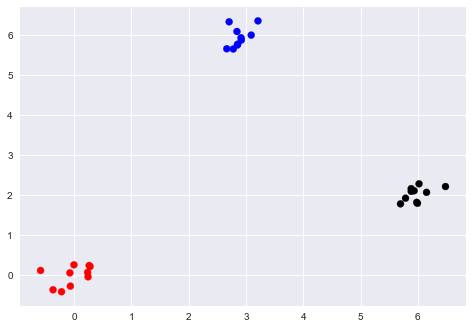

In [244]:
def get_data(n_clust = 3, n_points=50):
    X1 = np.random.normal(0,.3,n_points).reshape(-1,1)
    y1 = np.random.normal(0,.3,n_points).reshape(-1,1)
    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(0,10),.3,n_points).reshape(-1,1)
        y2 = np.random.normal(np.random.randint(0,10),.3,n_points).reshape(-1,1)
        X1 = np.vstack((X1,X2)).reshape(-1,1)
        y1 = np.vstack((y1,y2)).reshape(-1,1)
    X = np.hstack((X1,y1))
    return X

X = get_data(n_clust=3, n_points=10)
c = ['r']*10+['b']*10+['k']*10
plt.scatter(X[:,0],X[:,1], c=c);

In [245]:
ms = mean_shift(iters=20)

In [246]:
ms.fit(X)

In [247]:
X_pred = ms.transform(X)

In [248]:
X_pred

[array([-0.02297842, -0.0172123 ]),
 array([-0.02050309, -0.01480433]),
 array([-0.01886356, -0.01391141]),
 array([-0.01886352, -0.01386796]),
 array([-0.02537827, -0.01880736]),
 array([-0.02006437, -0.01505544]),
 array([-0.02371197, -0.01364294]),
 array([-0.02457534, -0.01842591]),
 array([-0.0250142 , -0.01764008]),
 array([-0.01968552, -0.01464188]),
 array([ 2.88193187,  5.93889903]),
 array([ 2.88123705,  5.93733315]),
 array([ 2.88184262,  5.93888343]),
 array([ 2.88204711,  5.939559  ]),
 array([ 2.88239818,  5.93886002]),
 array([ 2.88161375,  5.93573923]),
 array([ 2.88251117,  5.94031081]),
 array([ 2.88144815,  5.93782742]),
 array([ 2.88115867,  5.93721666]),
 array([ 2.8814157 ,  5.93774691]),
 array([ 5.97767827,  2.02431981]),
 array([ 5.97748414,  2.02214415]),
 array([ 5.97830981,  2.02281607]),
 array([ 5.97831559,  2.02272272]),
 array([ 5.97717804,  2.02188925]),
 array([ 5.97914252,  2.0232913 ]),
 array([ 5.97792466,  2.02252547]),
 array([ 5.97785062,  2.0224

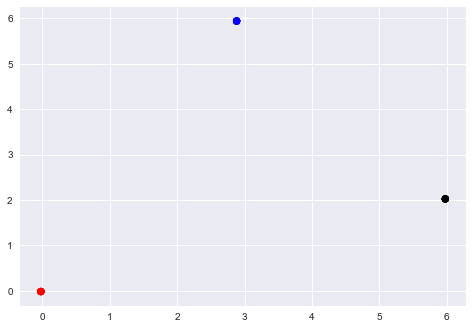

In [249]:
x, y = zip(*X_pred)
plt.scatter(x,y, c=c, alpha=0.5);

## Test in 3D

In [267]:
def get_multidim_data(n_clust = 3, num_dim=3):
    X = np.random.normal(-5,1,size=(50,3))

    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(-10,10),1,size=(50,3))
        X = np.vstack((X,X2))
    return X

X = get_multidim_data(n_clust=5)

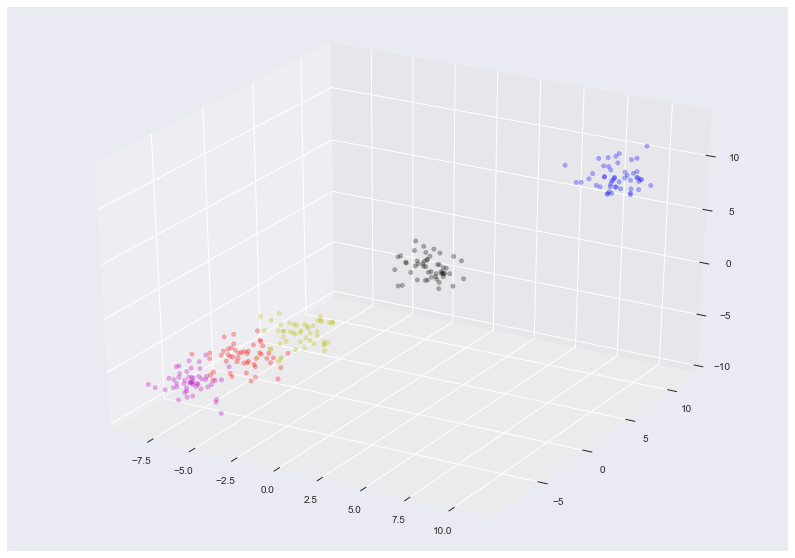

In [268]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')
col = ['r']*50+['b']*50+['y']*50+['m']*50+['k']*50

xplot, yplot, zplot = zip(*X)
ax.scatter(xplot,yplot, zplot, c=col,alpha=0.3);

In [275]:
ms = mean_shift(iters=20,threshold=0.01)
preds = ms.fit_transform(X)

In [276]:
preds

[array([-4.9342099 , -5.11435967, -4.63246587]),
 array([-4.90080499, -5.08295153, -4.6218918 ]),
 array([-4.90000023, -5.08209189, -4.62181298]),
 array([-4.93480339, -5.11433499, -4.63751411]),
 array([-4.92347837, -5.10513912, -4.63896017]),
 array([-4.89770624, -5.07988651, -4.62098514]),
 array([-4.90045714, -5.08235077, -4.62286306]),
 array([-4.93322706, -5.11303014, -4.63572781]),
 array([-4.93328076, -5.11299029, -4.63638219]),
 array([-4.93412449, -5.11377738, -4.63666231]),
 array([-4.93742887, -5.11675833, -4.63826145]),
 array([-4.90142897, -5.08344998, -4.62239437]),
 array([-4.93553398, -5.11513277, -4.63646446]),
 array([-4.93642859, -5.11586536, -4.63768978]),
 array([-7.05354815, -6.63130763, -6.93660159]),
 array([-4.89960464, -5.08170521, -4.62170879]),
 array([-4.89890699, -5.08105115, -4.62137009]),
 array([-4.89995516, -5.08204858, -4.62179693]),
 array([-4.90121552, -5.0832335 , -4.62238446]),
 array([-4.9336281 , -5.11331167, -4.63657167]),
 array([-4.90420917,

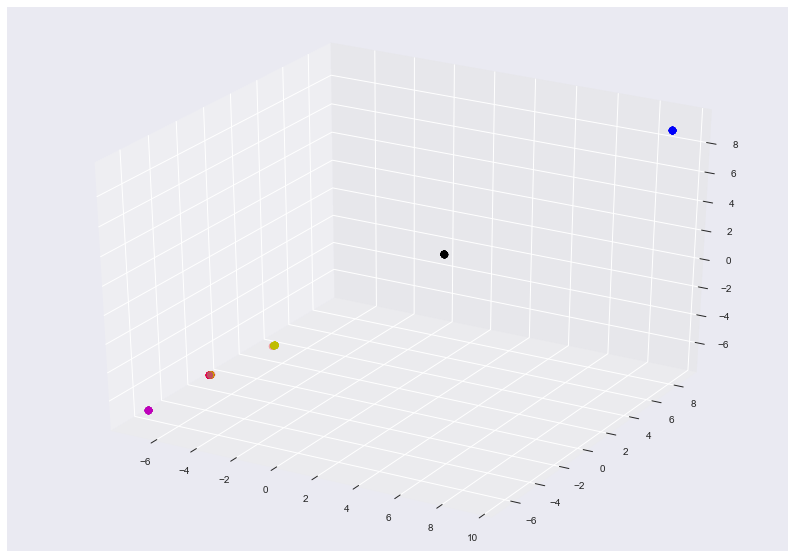

In [278]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')
col = ['r']*50+['b']*50+['y']*50+['m']*50+['k']*50

xplot, yplot, zplot = zip(*preds)
ax.scatter(xplot,yplot, zplot, c=col,alpha=0.3,s=50);
